In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from IPython.display import Image

In [2]:
from models.scripts.lstm import AssetDataset, AssetRelationshipModel, train_model_with_loss_curve, plot_correlation_matrix_with_labels
from models.scripts.correlation_analysis import load_data, calculate_returns, analyze_correlation, plot_correlation_heatmap, rolling_correlation_multi
from models.scripts.Vector_Autoregression_model import DataProcessor, VARModel, Plotter

In [3]:
input_file = "./processed_data/processed_data.csv"
output_dir = "./results"

In [4]:
prices = pd.read_csv(input_file, index_col=0, parse_dates=True)
normalized_data = (prices - prices.min()) / (prices.max() - prices.min())
data_values = normalized_data.values

seq_length = 10
input_size = data_values.shape[1]
hidden_size = 64
num_layers = 2
output_size = input_size
batch_size = 32
num_epochs = 10
learning_rate = 0.001

dataset = AssetDataset(data_values, seq_length)

In [5]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = AssetRelationshipModel(input_size, hidden_size, num_layers, output_size)

Missing values per column:
AGG    0
GLD    0
SPY    0
BTC    0
dtype: int64
Data index range: 2021-12-13 00:00:00 to 2024-12-10 00:00:00


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        32.42       32.44   1.201e+14       32.43
1       16.85*      16.98*  2.088e+07*      16.90*
2        16.88       17.10   2.141e+07       16.97
3        16.90       17.23   2.184e+07       17.02
4        16.92       17.34   2.225e+07       17.08
5        16.95       17.47   2.287e+07       17.15
6        16.95       17.58   2.308e+07       17.20
7        16.96       17.68   2.310e+07       17.24
8        16.99       17.82   2.390e+07       17.31
9        17.02       17.94   2.454e+07       17.37
10       17.04       18.06   2.503e+07       17.43
11       17.02       18.15   2.463e+07       17.45
12       17.03       18.26   2.502e+07       17.51
13       17.05       18.38   2.548e+07       17.57
14       17.07       18.50   2.601e+07       17.62
15       17.09       18.62   2.636e+07       17.68
16       17.10       18.73   2.

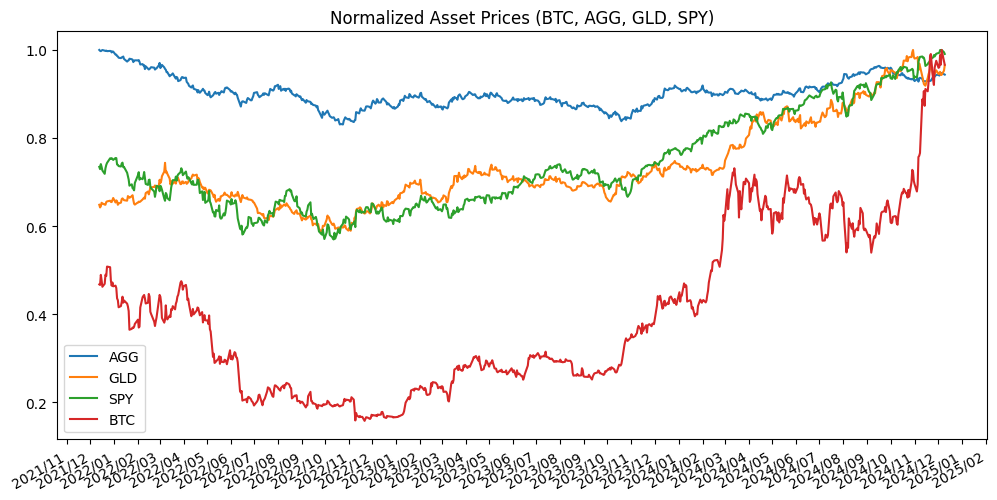

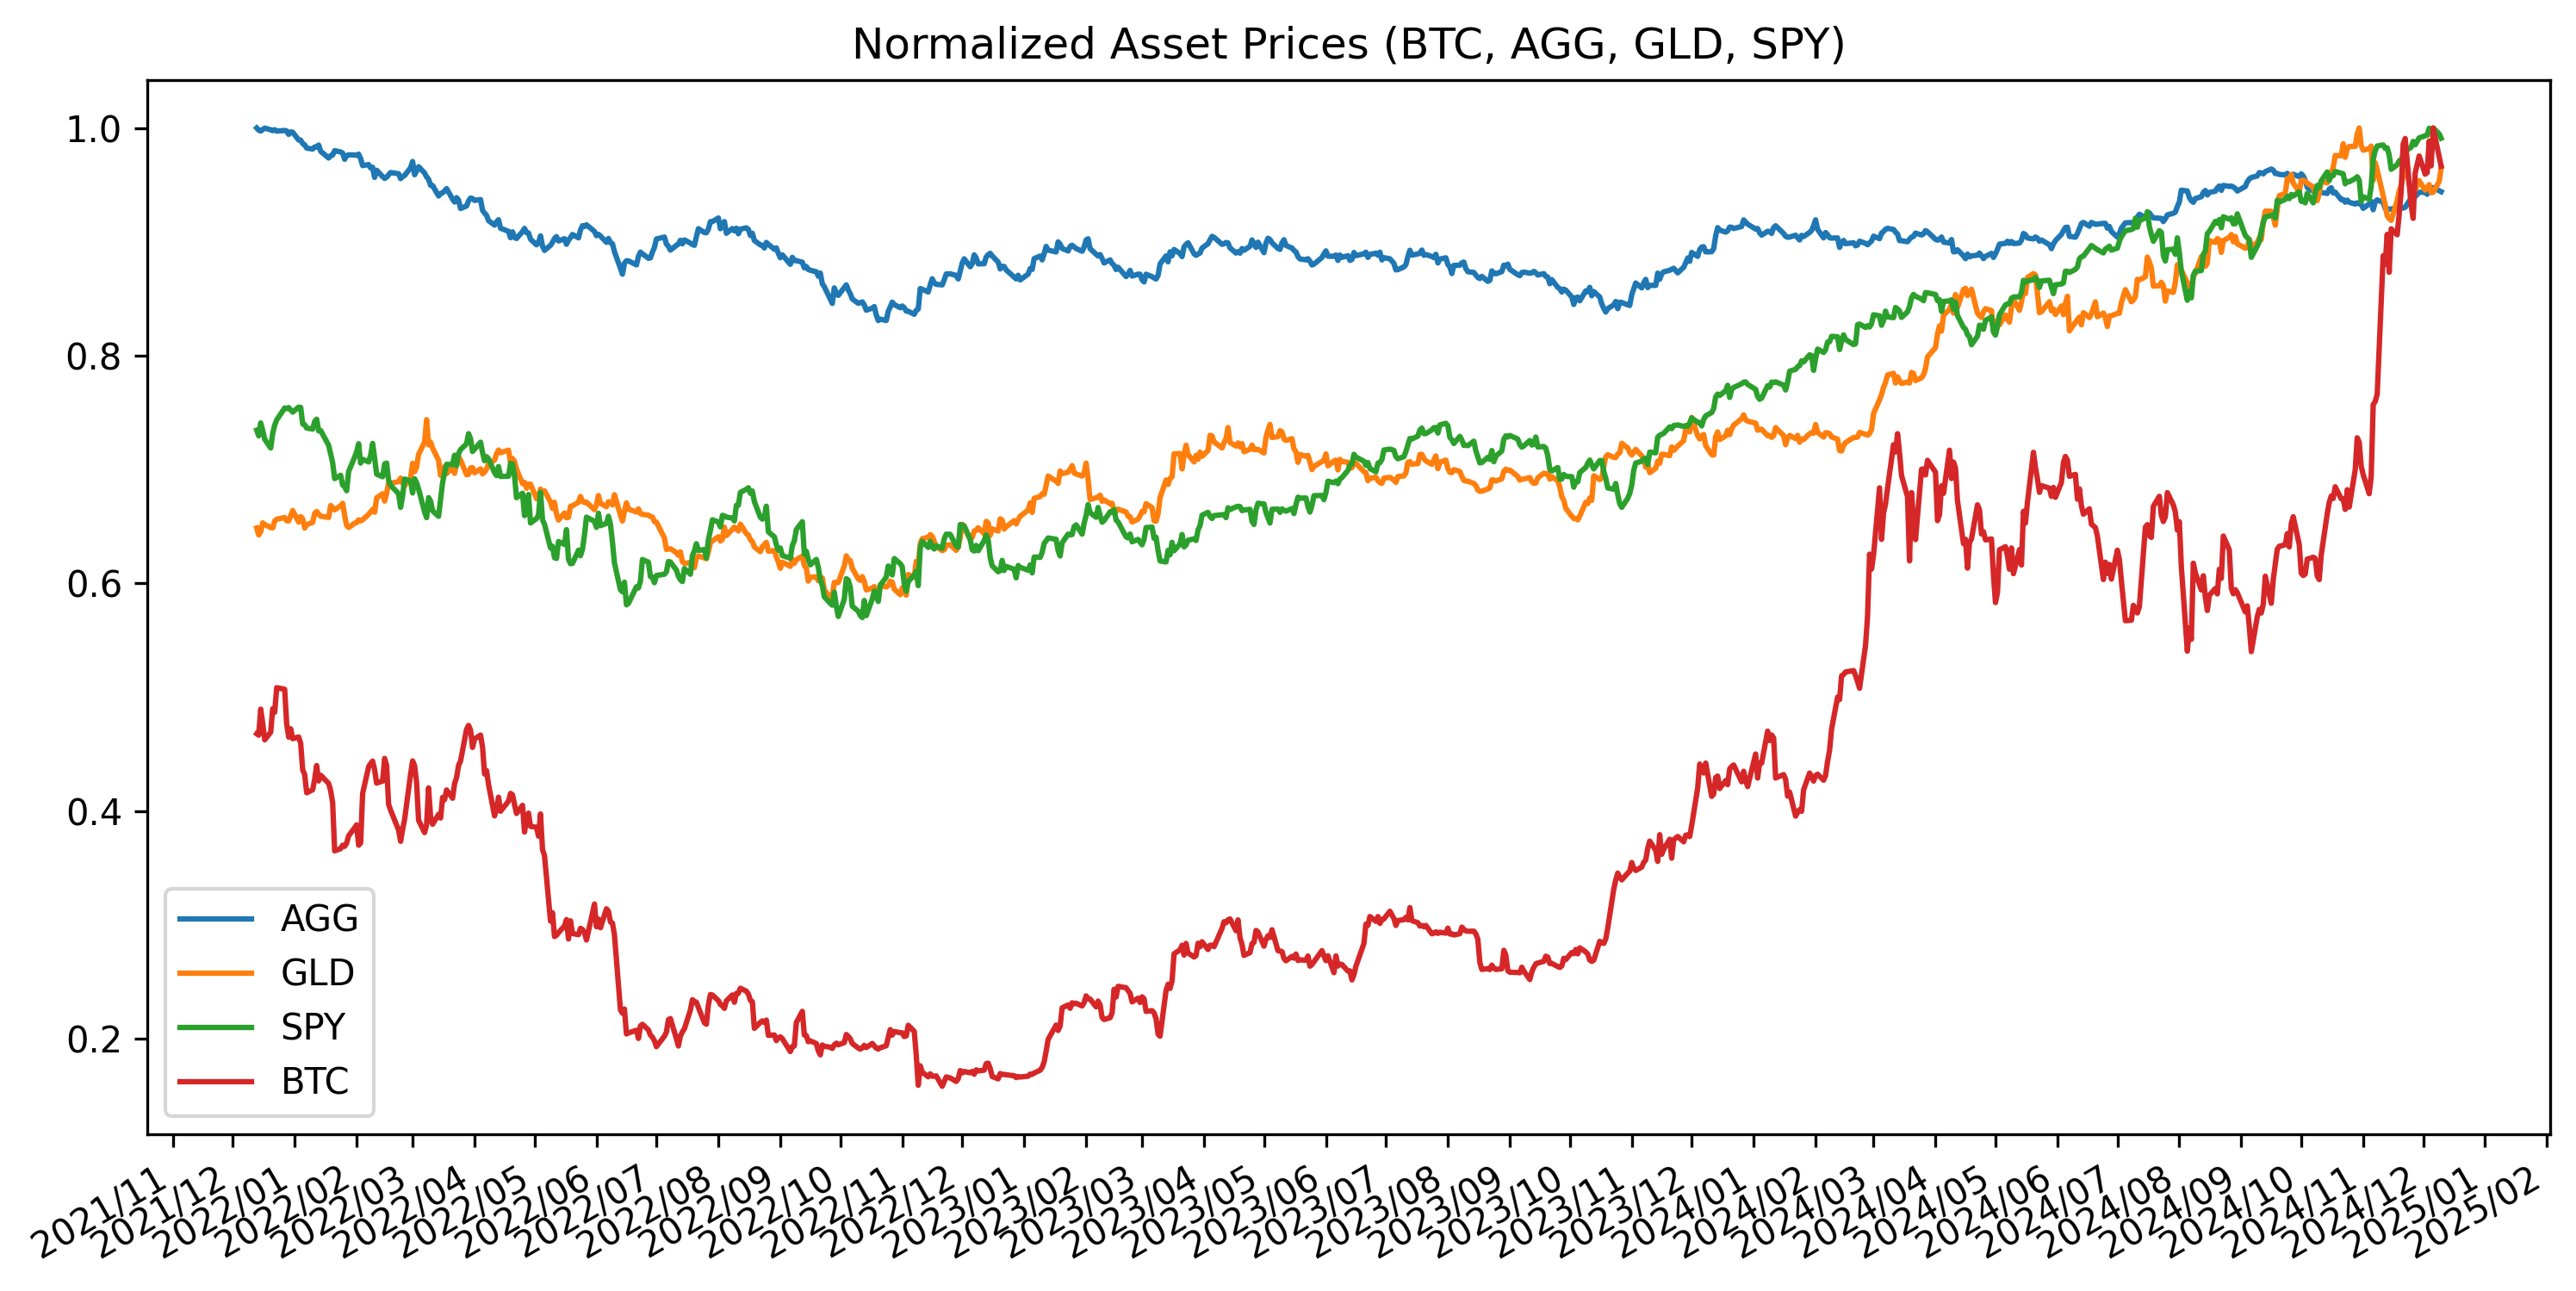

In [6]:
processor = DataProcessor(input_file)
data = processor.load_data()
processor.check_missing_values()
processor.fill_missing_values()
processor.check_date_range()
normalized_data_for_var = processor.normalize_data()

var_model = VARModel(data)
best_lag = var_model.select_best_lag()
var_model.fit_model(best_lag)
var_model.test_causality()

var_plot_path = os.path.join(output_dir, "normalized_asset_prices.png")
plotter = Plotter(normalized_data_for_var)
plotter.plot_normalized_data(var_plot_path)

Image(filename=var_plot_path)

Correlation heatmap with labels saved to ./results/lstm_correlation_heatmap_with_labels.png


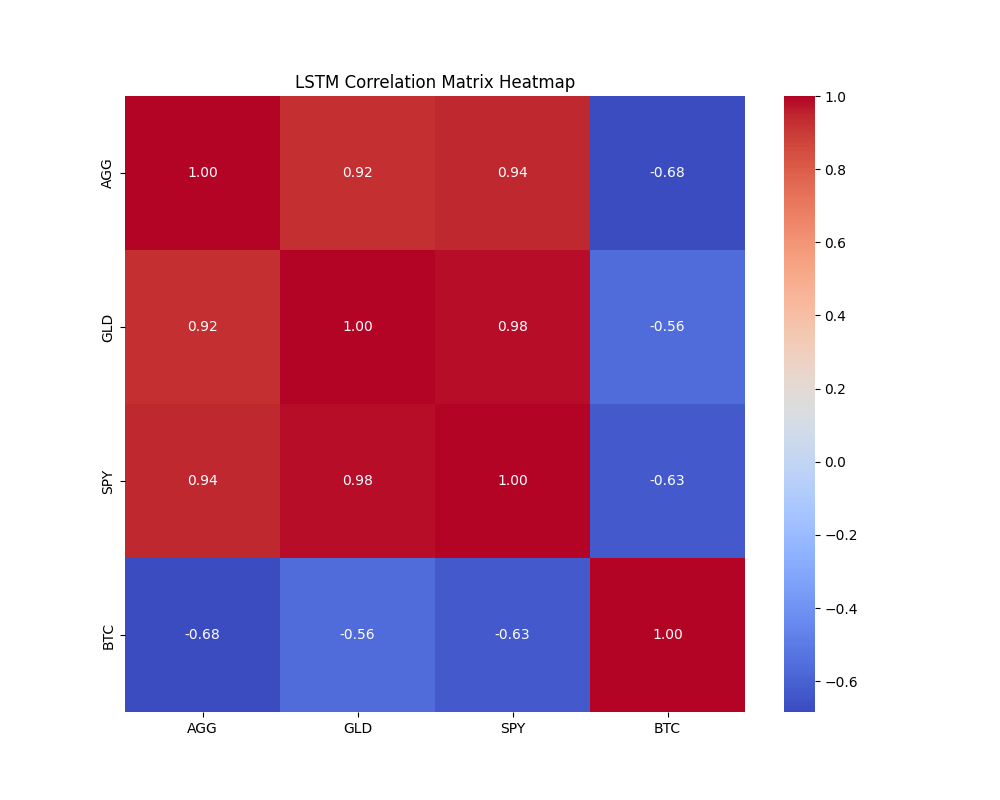

In [7]:
features = []
with torch.no_grad():
    for i in range(len(dataset)):
        inputs, _ = dataset[i]
        inputs = inputs.unsqueeze(0)
        feature = model(inputs).squeeze().numpy()
        features.append(feature)
features = np.array(features)

corr_matrix = np.corrcoef(features.T)
asset_labels = list(prices.columns)

corr_heatmap_path = os.path.join(output_dir, "lstm_correlation_heatmap_with_labels.png")
plot_correlation_matrix_with_labels(corr_matrix, asset_labels, corr_heatmap_path)
Image(filename=corr_heatmap_path)

Calculated daily returns:
                  AGG       GLD       SPY       BTC
Date                                              
2021-12-14 -0.001919 -0.009341 -0.006880 -0.002671
2021-12-15 -0.000787  0.004292  0.015625  0.049002
2021-12-16  0.001375  0.012098 -0.008818 -0.025182
2021-12-17  0.001224 -0.002141 -0.010643 -0.030699
2021-12-20 -0.001485 -0.004231 -0.010634  0.014678
Correlation Matrix:
           AGG       GLD       SPY       BTC
AGG  1.000000  0.422834  0.238848  0.093076
GLD  0.422834  1.000000  0.152723  0.105852
SPY  0.238848  0.152723  1.000000  0.415068
BTC  0.093076  0.105852  0.415068  1.000000
Correlation matrix saved to ./results/correlation_matrix.csv
Correlation heatmap saved to ./results/correlation_heatmap.png


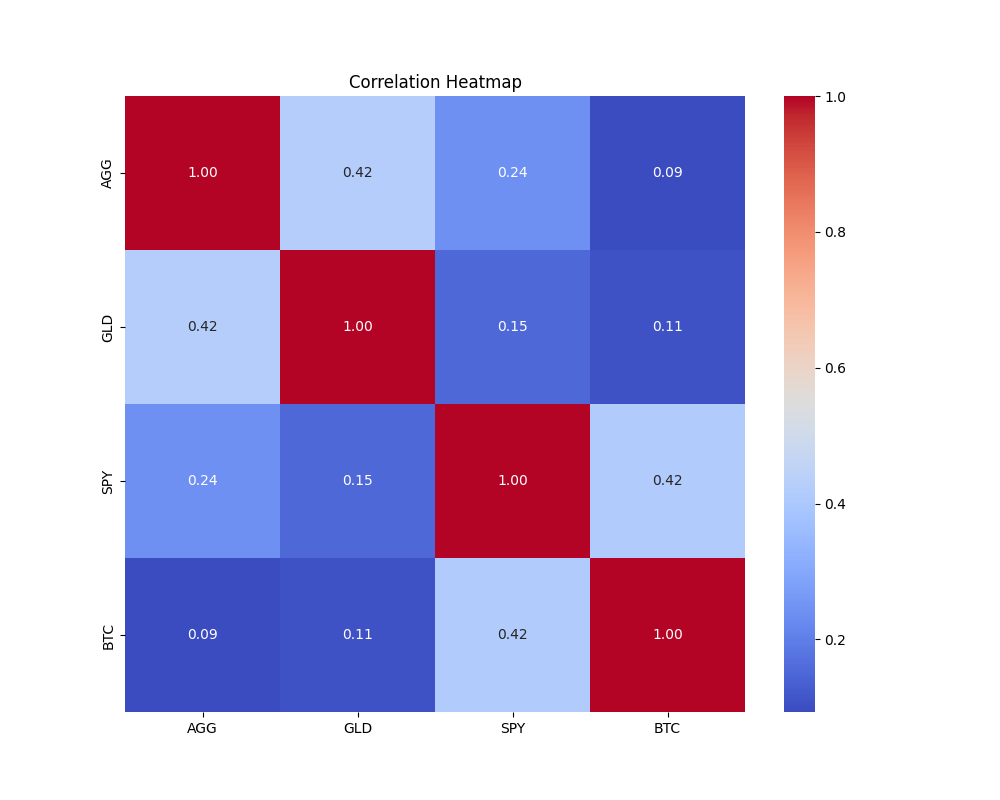

In [8]:
returns = calculate_returns(prices)
corr_csv = os.path.join(output_dir, "correlation_matrix.csv")
corr_matrix_returns = analyze_correlation(returns, output_path=corr_csv)

heatmap_path = os.path.join(output_dir, "correlation_heatmap.png")
plot_correlation_heatmap(corr_matrix_returns, title="Correlation Heatmap", output_path=heatmap_path)

Image(filename=heatmap_path)

Rolling correlation plot saved to ./results/rolling_correlation_multi.png


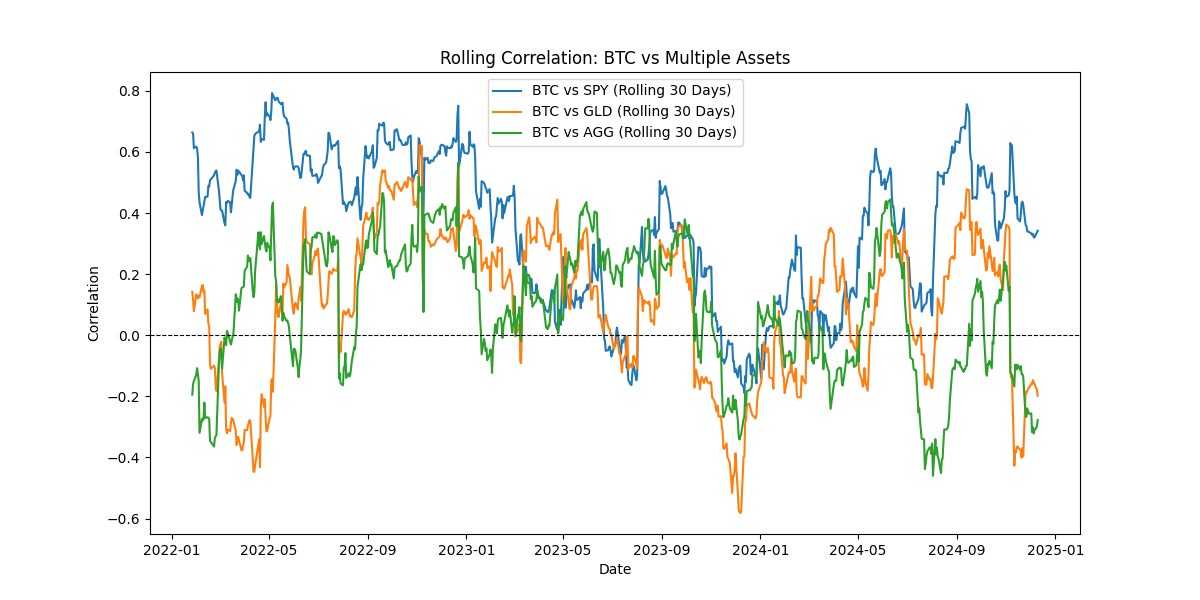

In [9]:
rolling_corr_path = os.path.join(output_dir, "rolling_correlation_multi.png")
rolling_correlation_multi(returns, base_asset="BTC", compare_assets=["SPY", "GLD", "AGG"], window=30, output_path=rolling_corr_path)

Image(filename=rolling_corr_path)
